Load Model

In [1]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch

# 1. Rebuild the exact same architecture
num_classes = 1 + 43   # change if you have a different number of classes
model = fasterrcnn_resnet50_fpn(pretrained=False)
in_feats = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_feats, num_classes)

# 2. Load your saved weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("fasterrcnn_gtsdb_weights.pth", map_location=device))
model.to(device).eval()
print("→ Model loaded, ready for inference")


C:\Users\eren\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\eren\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


→ Model loaded, ready for inference


Run Model And Visualize Frame

Detections (post‑NMS, thr=0.125): 2

Detection 1:
  Class: speed limit 50 (prohibitory)
  Score: 0.203
  BBox:  (1069, 382) → (1094, 410)

Detection 2:
  Class: speed limit 50 (prohibitory)
  Score: 0.189
  BBox:  (442, 418) → (473, 445)



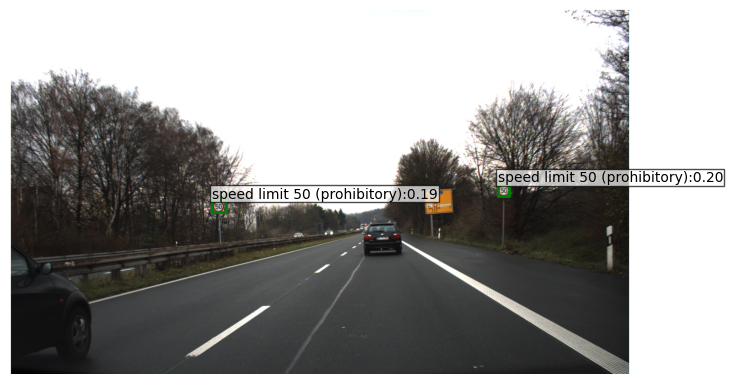

In [ ]:
import torch
from torchvision.ops import nms
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
import matplotlib.patches as patches

#Class names map 

class_names = {
    0:  "speed limit 20 (prohibitory)",
    1:  "speed limit 30 (prohibitory)",
    2:  "speed limit 50 (prohibitory)",
    3:  "speed limit 60 (prohibitory)",
    4:  "speed limit 70 (prohibitory)",
    5:  "speed limit 80 (prohibitory)",
    6:  "restriction ends 80 (other)",
    7:  "speed limit 100 (prohibitory)",
    8:  "speed limit 120 (prohibitory)",
    9:  "no overtaking (prohibitory)",
    10: "no overtaking (trucks) (prohibitory)",
    11: "priority at next intersection (danger)",
    12: "priority road (other)",
    13: "give way (other)",
    14: "stop (other)",
    15: "no traffic both ways (prohibitory)",
    16: "no trucks (prohibitory)",
    17: "no entry (other)",
    18: "danger (danger)",
    19: "bend left (danger)",
    20: "bend right (danger)",
    21: "bend (danger)",
    22: "uneven road (danger)",
    23: "slippery road (danger)",
    24: "road narrows (danger)",
    25: "construction (danger)",
    26: "traffic signal (danger)",
    27: "pedestrian crossing (danger)",
    28: "school crossing (danger)",
    29: "cycles crossing (danger)",
    30: "snow (danger)",
    31: "animals (danger)",
    32: "restriction ends (other)",
    33: "go right (mandatory)",
    34: "go left (mandatory)",
    35: "go straight (mandatory)",
    36: "go right or straight (mandatory)",
    37: "go left or straight (mandatory)",
    38: "keep right (mandatory)",
    39: "keep left (mandatory)",
    40: "roundabout (mandatory)",
    41: "restriction ends (overtaking) (other)",
    42: "restriction ends (overtaking (trucks)) (other)",
}

#Prep
device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()
transform = T.ToTensor()

#Load & preprocess
img_path = r"c:\Users\eren\Desktop\AI Traffic sign detect\RCNN\TestIJCNN2013Download\00238.ppm"
img      = Image.open(img_path).convert("RGB")
img_t    = transform(img).to(device)

#Inference
with torch.no_grad():
    outputs = model([img_t])[0]

#Filter by confidence threshold
threshold   = 0.125
all_scores  = outputs["scores"]
mask        = all_scores > threshold

boxes_all   = outputs["boxes"][mask]
labels_all  = outputs["labels"][mask]
scores_all  = all_scores[mask]

#Class agnostic NMS 
iou_thresh  = 0.5
keep_idxs   = nms(boxes_all, scores_all, iou_thresh)

#sort by descending score
keep_idxs   = keep_idxs[torch.argsort(scores_all[keep_idxs], descending=True)]

final_boxes  = boxes_all[keep_idxs].cpu()
final_labels = labels_all[keep_idxs].cpu()
final_scores = scores_all[keep_idxs].cpu()

#Print each kept detection
print(f"Detections (post‑NMS, thr={threshold}): {len(final_boxes)}\n")
for i, (box, lbl, scr) in enumerate(zip(final_boxes, final_labels, final_scores), start=1):
    x1, y1, x2, y2 = map(int, box.tolist())
    name = class_names[int(lbl)]
    print(f"Detection {i}:")
    print(f"  Class: {name}")
    print(f"  Score: {scr:.3f}")
    print(f"  BBox:  ({x1}, {y1}) → ({x2}, {y2})\n")

#Visualize
fig, ax = plt.subplots(1, figsize=(8,6))
ax.imshow(img)
for box, lbl, scr in zip(final_boxes, final_labels, final_scores):
    x1, y1, x2, y2 = map(int, box.tolist())
    name = class_names[int(lbl)]
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                             linewidth=2, edgecolor='g', facecolor='none')
    ax.add_patch(rect)
    ax.text(x1, y1-5, f"{name}:{scr:.2f}",
            fontsize=10, bbox=dict(facecolor='white', alpha=0.7, pad=1))
ax.axis('off')
plt.show()


Run Model for 100 Images to Inspect them by eye

In [3]:
import os
import torch
from torchvision.ops import nms
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
import matplotlib.patches as patches



# 2. Prep once
device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()
transform = T.ToTensor()

threshold  = 0.125
iou_thresh = 0.5

base_dir   = r"c:\Users\eren\Desktop\AI Traffic sign detect\RCNN\TestIJCNN2013Download"
out_dir    = r"c:\Users\eren\Desktop\AI Traffic sign detect\RCNN\Detections"
os.makedirs(out_dir, exist_ok=True)

# 3. Loop over all 100 images
for i in range(100):
    img_name = f"{i:05d}.ppm"
    img_path = os.path.join(base_dir, img_name)
    if not os.path.isfile(img_path):
        print(f"⚠️  Skipping missing file: {img_name}")
        continue

    # Load & preprocess
    img   = Image.open(img_path).convert("RGB")
    img_t = transform(img).to(device)

    # Inference
    with torch.no_grad():
        outputs = model([img_t])[0]

    # Filter by confidence
    mask       = outputs["scores"] > threshold
    boxes      = outputs["boxes"][mask]
    labels     = outputs["labels"][mask]
    scores     = outputs["scores"][mask]

    # NMS
    keep       = nms(boxes, scores, iou_thresh)
    keep       = keep[torch.argsort(scores[keep], descending=True)]

    final_boxes  = boxes[keep].cpu()
    final_labels = labels[keep].cpu()
    final_scores = scores[keep].cpu()

    # Print summary
    print(f"\n=== {img_name} : {len(final_boxes)} detections (thr={threshold}) ===")
    for idx, (b, lbl, sc) in enumerate(zip(final_boxes, final_labels, final_scores), 1):
        x1, y1, x2, y2 = b.int().tolist()
        print(f"  {idx:2d}. {class_names[int(lbl)]:30s}  {sc:.3f}  [{x1},{y1},{x2},{y2}]")

    # Visualize & save
    fig, ax = plt.subplots(1, figsize=(8,6))
    ax.imshow(img)
    for box, lbl, scr in zip(final_boxes, final_labels, final_scores):
        x1, y1, x2, y2 = box.int().tolist()
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                 linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1-5, f"{class_names[int(lbl)]}:{scr:.2f}",
                fontsize=10, bbox=dict(facecolor='white', alpha=0.7, pad=1))
    ax.axis('off')

    save_path = os.path.join(out_dir, f"{i:05d}_det.png")
    fig.savefig(save_path, bbox_inches='tight', pad_inches=0.1)
    plt.close(fig)
    print(f"Saved visualization to: {save_path}")



=== 00000.ppm : 0 detections (thr=0.125) ===
Saved visualization to: c:\Users\eren\Desktop\AI Traffic sign detect\RCNN\Detections\00000_det.png

=== 00001.ppm : 1 detections (thr=0.125) ===
   1. speed limit 50 (prohibitory)    0.129  [82,447,143,510]
Saved visualization to: c:\Users\eren\Desktop\AI Traffic sign detect\RCNN\Detections\00001_det.png

=== 00002.ppm : 2 detections (thr=0.125) ===
   1. speed limit 50 (prohibitory)    0.258  [444,544,477,571]
   2. speed limit 50 (prohibitory)    0.190  [1268,555,1299,583]
Saved visualization to: c:\Users\eren\Desktop\AI Traffic sign detect\RCNN\Detections\00002_det.png

=== 00003.ppm : 1 detections (thr=0.125) ===
   1. speed limit 50 (prohibitory)    0.143  [359,445,413,500]
Saved visualization to: c:\Users\eren\Desktop\AI Traffic sign detect\RCNN\Detections\00003_det.png

=== 00004.ppm : 1 detections (thr=0.125) ===
   1. priority at next intersection (danger)  0.147  [367,484,437,542]
Saved visualization to: c:\Users\eren\Desktop\AI T